# Knife Edge Measurements Testing
---
## Module near field image

In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


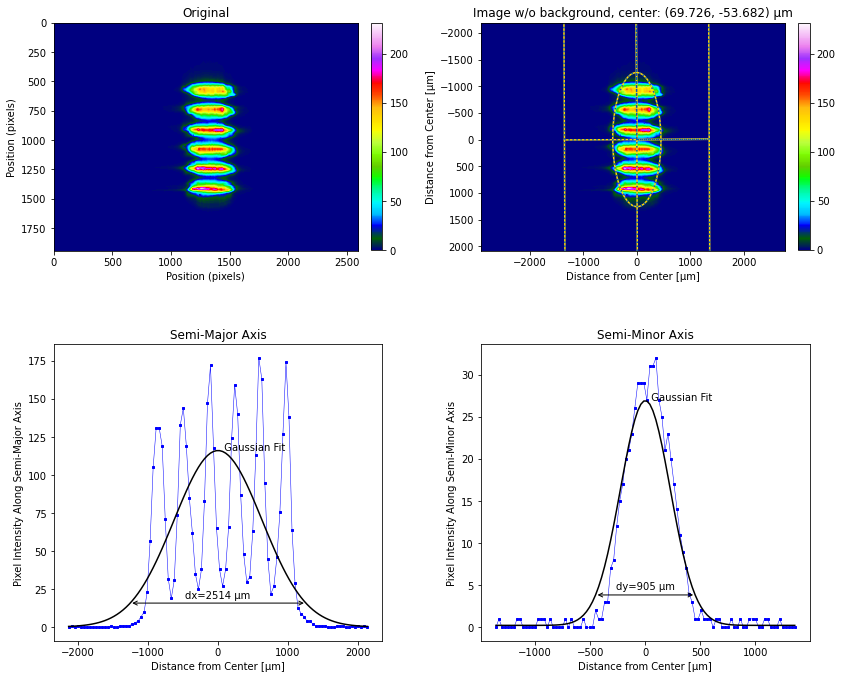

In [90]:
import requests
import sys
import os
# from inspect import getmembers, isfunction
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Import from this directory so we can rapidly test
sys.path.append('../') # Needed for import
import laserbeamtools as lbs

def load_img(file, folder = r'../tests/test_beam_profiles/DAS'):
    """ Load an image into an array """
    full_path = folder + '/' + file
    if os.path.isfile(full_path):
        iobj = Image.open(full_path)
        img = np.asarray(iobj)
        return img
    else:
        print("No file found under:")
        print(full_path)
        return None

# x, y, dx, dy, phi = lbs.beam_size(img)
# print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
# print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
# print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
# print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

img = load_img('nf_100_1234.bmp')
lbs.plot_image_analysis(img, pixel_size=2.2)
plt.show()

## Module Far Fields
### Far Field From Rows 1 & 2

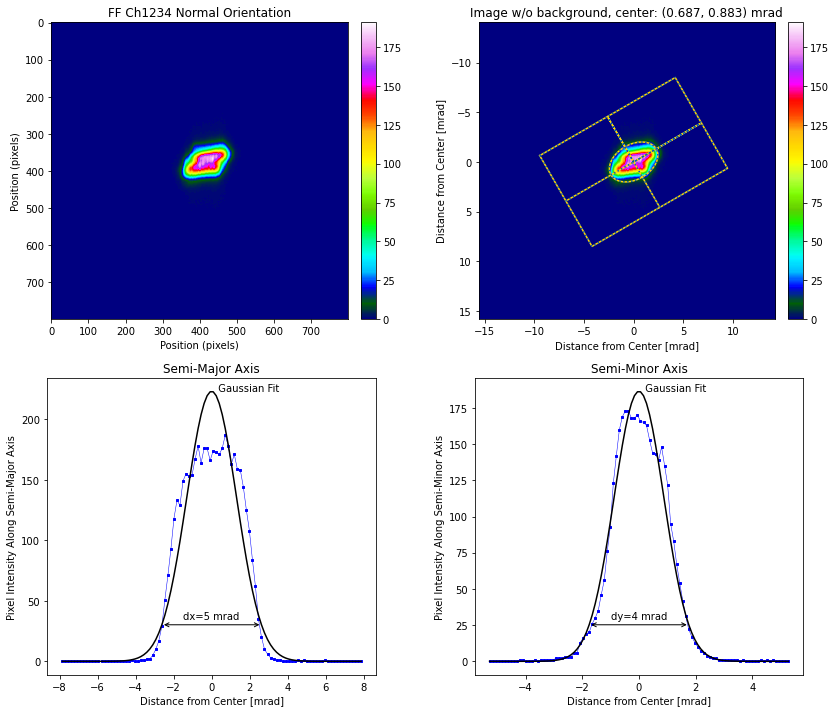

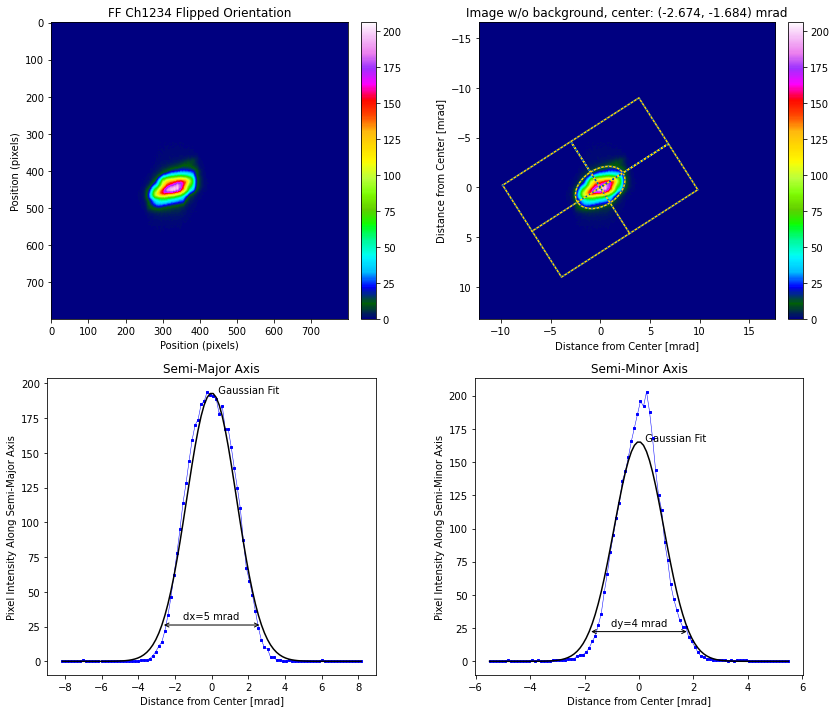

In [91]:

img = load_img('ff_1234.bmp')
y,x =img.shape

y = int(y/2) # Y center
x = int(x/2) # X center
d = 400

img = img[y-d:y+d,x-d:x+d]

# img = img/np.sum(img)
lbs.plot_image_analysis(img, pixel_size=2.2, title='FF Ch1234 Normal Orientation', far_field_lens=59, units='mrad')
plt.show()

img = load_img('ff_flip_1234.bmp')
img = img[y-d:y+d,x-d:x+d]
lbs.plot_image_analysis(img, pixel_size=2.2, title='FF Ch1234 Flipped Orientation', far_field_lens=59, units='mrad')
plt.show()

# Issue With Current Method

The center of the beam ellipse is at (174, 164)
The ellipse diameter (closest to horizontal) is 84 pixels
The ellipse diameter (closest to   vertical) is 26 pixels
The ellipse is rotated 33° ccw from the horizontal


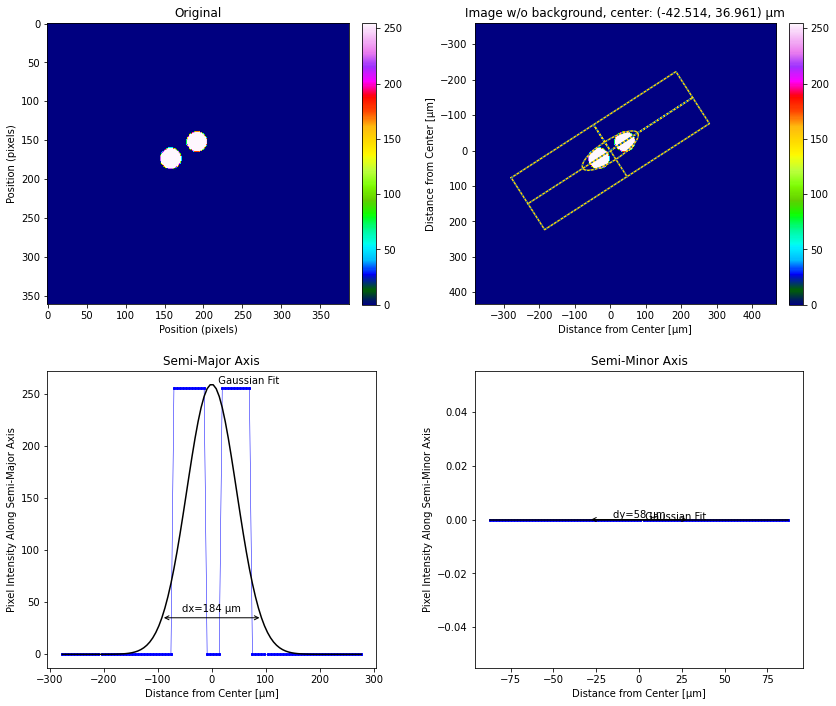

In [92]:

full_path = r'../tests/test_beam_profiles/TST/test.png'
if os.path.isfile(full_path):
    iobj = Image.open(full_path).convert('L')
    img = np.asarray(iobj)

else:
    print("No file found under:")
    print(full_path)


x, y, dx, dy, phi = lbs.beam_size(img)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

lbs.plot_image_analysis(img, pixel_size=2.2)
plt.show()

# Test Knife Edge Math

152911.66176796143


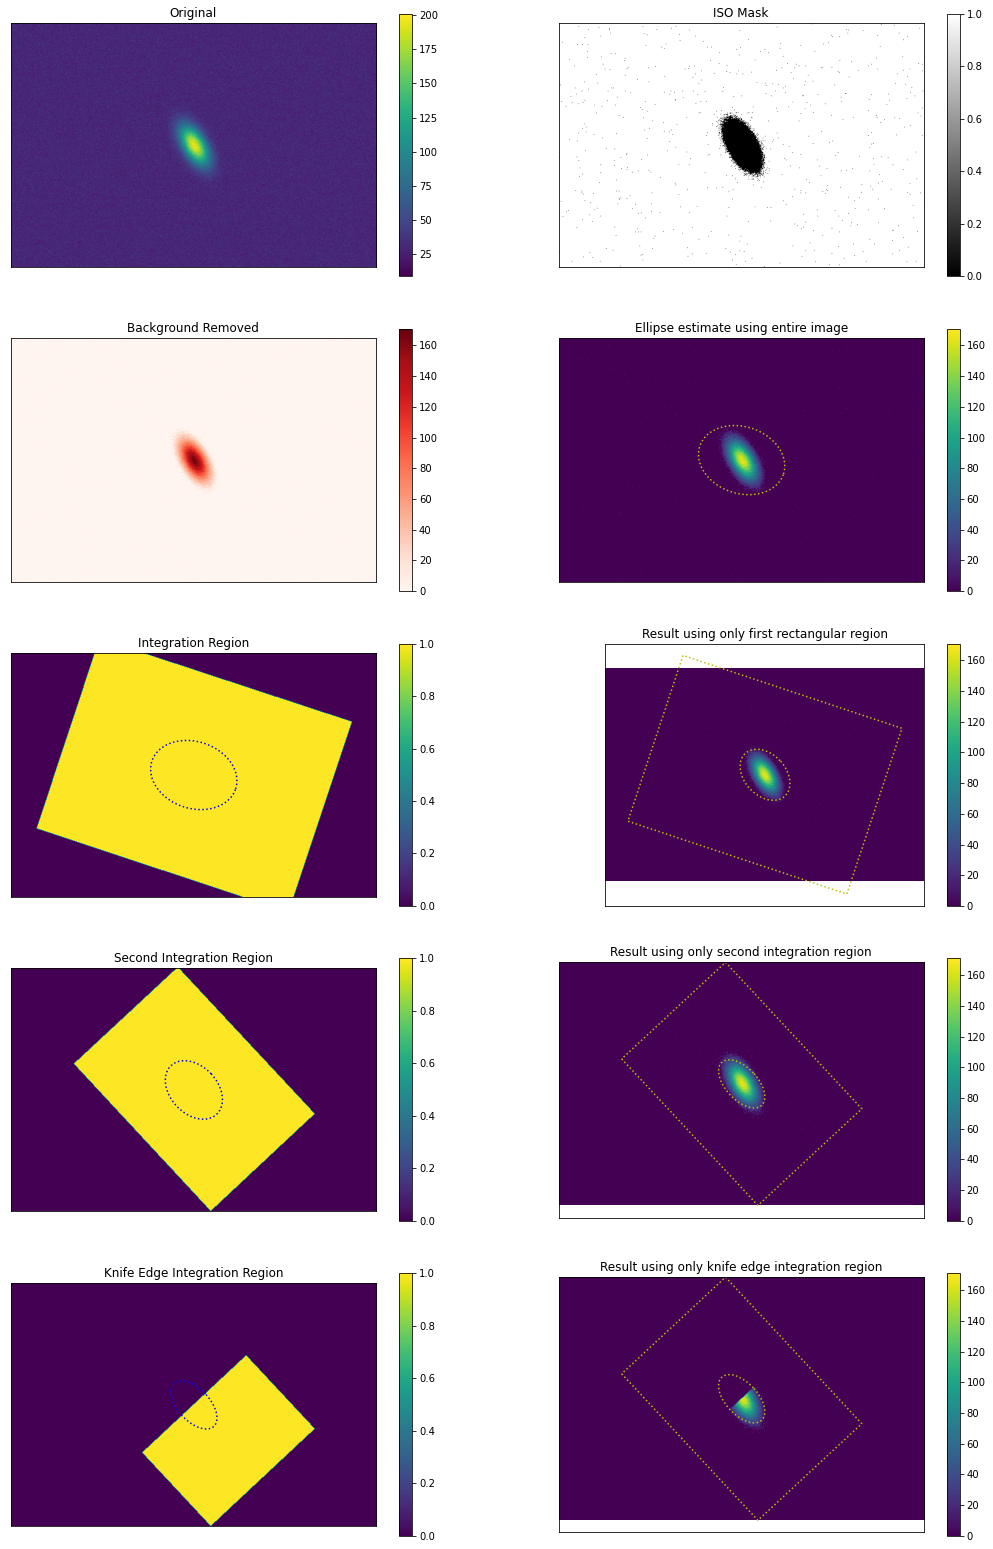

took 0.288 seconds


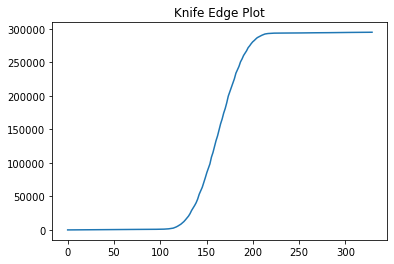

In [94]:
import numpy as np
import time

xc, yc, dx, dy, phi = 300, 200, 100, 50, np.radians(-60)
h, v = 600, 400
max_value=1023
noise = 30

# generate test image
test = lbs.create_test_image(h,v,xc,yc,dx,dy,phi,noise=noise)

plt.subplots(5,2,figsize=(18,28))

# -------------------------------------------------------------------------------------------- #

plt.subplot(5,2,1)
plt.imshow(test)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Original')

# -------------------------------------------------------------------------------------------- #
# corners
corners = lbs.corner_mask(test)
plt.subplot(5,2,2)
plt.imshow(lbs.iso_background_mask(test), cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('ISO Mask')

# remove background
zeroed = lbs.subtract_iso_background(test, iso_noise=False)

plt.subplot(5,2,3)
plt.imshow(zeroed, cmap=lbs.create_plus_minus_cmap(zeroed))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Background Removed')

# -------------------------------------------------------------------------------------------- #

# first guess at beam parameters
xc, yc, dx, dy, phi = lbs.basic_beam_size(zeroed)

plt.subplot(5,2,4)
plt.imshow(zeroed)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.ellipse_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':y')
plt.title('Ellipse estimate using entire image')

# -------------------------------------------------------------------------------------------- #

mask = lbs.rotated_rect_mask(zeroed, xc, yc, dx, dy, phi)

plt.subplot(5,2,5)
plt.imshow(mask)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.ellipse_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':b')
plt.title('Integration Region')

masked_image = np.copy(zeroed)
masked_image[mask < 1] = 0       # zero all values outside mask

# -------------------------------------------------------------------------------------------- #

# first guess at beam parameters
xc1, yc1, dx1, dy1, phi1 = lbs.basic_beam_size(masked_image)

plt.subplot(5,2,6)
plt.imshow(masked_image)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.rotated_rect_arrays(xc, yc, dx, dy, phi)
plt.plot(xp,yp,':y')
xp,yp = lbs.ellipse_arrays(xc1, yc1, dx1, dy1, phi1)
plt.plot(xp,yp,':y')
plt.title('Result using only first rectangular region')

# -------------------------------------------------------------------------------------------- #

# second pass
mask = lbs.rotated_rect_mask(zeroed, xc1, yc1, dx1, dy1, phi1)

plt.subplot(5,2,7)
plt.imshow(mask)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.ellipse_arrays(xc1, yc1, dx1, dy1, phi1)
plt.plot(xp,yp,':b')
plt.title('Second Integration Region')

masked_image = np.copy(zeroed)
masked_image[mask < 1] = 0       # zero all values outside mask

# -------------------------------------------------------------------------------------------- #

# first guess at beam parameters
xc2, yc2, dx2, dy2, phi2 = lbs.basic_beam_size(masked_image)

plt.subplot(5,2,8)
plt.imshow(masked_image)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.rotated_rect_arrays(xc1, yc1, dx1, dy1, phi1)
plt.plot(xp,yp,':y')

xp,yp = lbs.ellipse_arrays(xc2, yc2, dx2, dy2, phi1)
plt.plot(xp,yp,':y')
plt.title('Result using only second integration region')

# -------------------------------------------------------------------------------------------- #
# -------------------------------------------------------------------------------------------- #
# -------------------------------------------------------------------------------------------- #

def knife_edge_mask222(image, xc, yc, dx, dy, phi, s_f, mask_diameters=3, dir = 'x'):
    """
    Creates a knife edge mask

    TODO
    - Add more to the description

    Args:
        image: the image to work with
        xc: horizontal center of beam
        yc: vertical center of beam
        dx: ellipse diameter for axis closest to horizontal
        dy: ellipse diameter for axis closest to vertical
        phi: angle that elliptical beam is rotated [radians]
        s_f: scale factor of how much to shrink mask
        mask_diameters: (optional) number of diameters to include
        dir: (optional) direction of knife edge ['x' or 'y']

    Returns:
        masked_image: 2D array with True values inside knife edge rectangle
    """
    # knife edge with blade moving in x direction
    if dir == 'x':
        # scaled down dx
        sdx = s_f * dx

        # difference between scaled and non-scaled
        ddx = (dx - sdx) / 2

        # projection scalars
        s = np.sin(-phi)
        c = np.cos(-phi)

        # define offsets from start coords
        ddx_x = ddx * c * mask_diameters    
        ddy_x = ddx * s * mask_diameters

        # define new start coords for rotated rect mask
        xc_2 = xc - ddx_x
        yc_2 = yc - ddy_x

        return lbs.rotated_rect_mask(image, xc_2, yc_2, sdx, dy, phi)
    
    # knife edge with blade moving in y direction
    elif dir == 'y':
        # Scaled down dy
        sdy = s_f * dy

        # difference between scaled and non-scaled
        ddy = (dy - sdy) / 2 

        # projection scalars
        s = np.sin(-phi)
        c = np.cos(-phi)

        # define offsets from start coords
        ddx_y = ddy * s * mask_diameters    
        ddy_y = ddy * c * mask_diameters

        # define new start coords for rotated rect mask
        xc_2 = xc - ddx_y
        yc_2 = yc + ddy_y

        return lbs.rotated_rect_mask(image, xc_2, yc_2, dx, sdy, phi)

    # invalid input
    else:
        raise ValueError("dir needs to be 'x' or 'y'")
        return None



# TESTING
plt.subplot(5,2,9)


mask = knife_edge_mask(zeroed, xc1, yc1, dx1, dy1, phi1, .5, dir = 'y')

# plt.subplot(5,2,5)
plt.imshow(mask)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.ellipse_arrays(xc2, yc2, dx2, dy2, phi1)
plt.plot(xp,yp,':b')
plt.title('Knife Edge Integration Region')

masked_image = np.copy(zeroed)
masked_image[mask < 1] = 0       # zero all values outside mask

print(np.sum(masked_image))

# -------------------------------------------------------------------------------------------- #

# TESTING
plt.subplot(5,2,10)

# xc2, yc2, dx2, dy2, phi2 = lbs.basic_beam_size(masked_image)

# plt.subplot(5,2,8)
plt.imshow(masked_image)
plt.colorbar()
plt.xticks([])
plt.yticks([])
xp,yp = lbs.rotated_rect_arrays(xc1, yc1, dx1, dy1, phi1)
plt.plot(xp,yp,':y')

xp,yp = lbs.ellipse_arrays(xc2, yc2, dx2, dy2, phi1)
plt.plot(xp,yp,':y')
plt.title('Result using only knife edge integration region')

plt.show()

# -------------------------------------------------------------------------------------------- #

x_axis = np.linspace(0,1,200)
y_axis = np.full_like(x_axis, 0.0)

time1 = time.time()
for i, x_val in enumerate(x_axis):
    mask = knife_edge_mask(zeroed, xc1, yc1, dx1, dy1, phi1, x_val, dir = 'y')
    masked_image = np.copy(zeroed)
    masked_image[mask < 1] = 0
    y_axis[i] = np.sum(masked_image)

time2 = time.time()

plt.figure(2)
plt.title("Knife Edge Plot")
plt.plot(x_axis * dy1 * 3, y_axis)

print("took {:.3f} seconds".format(time2-time1))
# print(time2-time1)

plt.show()

# Knife Edge Plot With DAS Beam

In [ ]:
img = load_img('ff_1234.bmp')
y,x =img.shape

y = int(y/2) # Y center
x = int(x/2) # X center
d = 400

img = img[y-d:y+d,x-d:x+d]

# img = img/np.sum(img)
lbs.plot_image_analysis(img, pixel_size=2.2, title='FF Ch1234 Normal Orientation', far_field_lens=59, units='mrad')
plt.show()